In [1]:
cd '/home/jovyan/GA_DSI/Projects/capstone'

/home/jovyan/GA_DSI/Projects/capstone


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import display
from sys import getsizeof
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# storing data directories for this notebook.
img_out_dir = '../data/images/EDA_NB1/'
data_out_dir = '../data/pickled/EDA_NB1/'

# used to print word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

%matplotlib inline

## Airline Sentiment Classification

Dataset Description from Kaggle:<br>
Classifies customer sentiment towards major U.S. airlines, based on twitter data. Tweets were scraped from February of 2015 and contributors were asked to classify tweets by positive, negative, and neutral categories, followed by categorizing negative reasons (such as “late flight” or “rude service”).

The Kaggle Dataset contains tweets and categories for 14,640k airline related tweets, classified into one of 3 sentiment categories (positive, negative, neutral). 
<br>Let's see if I can accurately classify the tweet sentiment category based on the text.

1. Load the data
2. Explore and clean the data:
  1. Standardize case (lower or upper?)
  2. Remove stop words
  3. Lemmatize or stem
3. Modeling with `Pipeline` and `GridSearchCV`
  1. Does `CountVectorizer` or `TfidfVectorizer` perform better as a preprocessing step?
  2. Test out different classifiers. Which model do I choose?
  3. Evaluate the classifier by analyzing the confusion matrix and classification report. 
4. Look at the classifier words:
  1. What are the top words for each category?
  2. Make a wordcloud for each category.

### EDA on first 8000 rows of dataset. Had to split rows since calculating the sum of the columns<br>used to kill the kernel.

In [2]:
# reading in 8000 rows but dataset has 14640. I get performance issues.

In [2]:
air_full_df = pd.read_csv("../data/csvfiles/kaggle_airline_dataset.csv", encoding='utf-8', nrows=8000)

In [4]:
air_full_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# data size of full kaggle dataset.
air_full_df.shape

(8000, 15)

In [6]:
air_full_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
air_full_df.airline_sentiment.value_counts()

negative    4560
neutral     1954
positive    1486
Name: airline_sentiment, dtype: int64

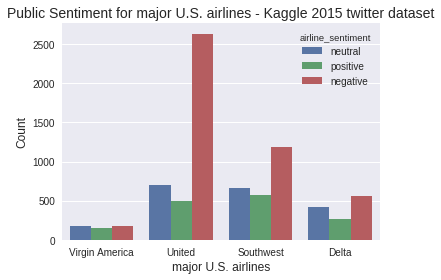

In [8]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=air_full_df)
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_airline_sentiment_hist.png')

In [9]:
# What are reasons for customer dissatisfaction?
# Explore this to make recommendations at the end from findings.

In [10]:
# plot negative reason value_counts.
neg_reason = air_full_df.negativereason[air_full_df.negativereason.notnull()]
neg_reason.value_counts()

Customer Service Issue         1233
Late Flight                     864
Can't Tell                      680
Lost Luggage                    396
Cancelled Flight                384
Bad Flight                      362
Flight Booking Problems         258
Flight Attendant Complaints     250
longlines                        92
Damaged Luggage                  41
Name: negativereason, dtype: int64

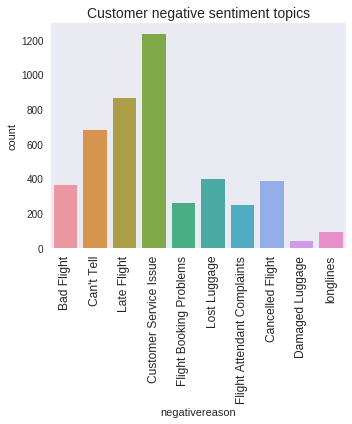

In [11]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=air_full_df)
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_customer_neg_sent_topics_hist.png')

In [12]:
# airlines 
air_full_df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta'], dtype=object)

In [13]:
# data types
air_full_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [14]:
# check for null values.
air_full_df.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3440
negativereason_confidence       2628
airline                            0
airline_sentiment_gold          7983
name                               0
negativereason_gold             7987
retweet_count                      0
text                               0
tweet_coord                     7388
tweet_created                      0
tweet_location                  2478
user_timezone                   2536
dtype: int64

In [15]:
# get subset with cols = ['airline', 'text', 'airline_sentiment', 'airline_sentiment:confidence']

In [4]:
sub_cols = ['text', 'airline_sentiment', 'airline_sentiment_confidence', 
            'negativereason', 'airline']
air_sub_df = air_full_df.loc[:, sub_cols]

In [5]:
del air_full_df

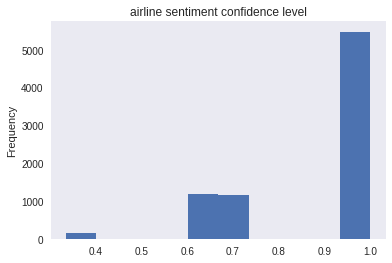

In [22]:
# look at the confidence of values for the 3 categories.
air_sub_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')
plt.grid(0)

In [23]:
# let's only keep tweets where the airline_sentiment_confidence is > 0.7

In [6]:
mask = air_sub_df.airline_sentiment_confidence >= 0.7

air_sub_df = air_sub_df.loc[mask,:]

In [7]:
# dataframe with airline sentiment data with 
air_sub_df.shape

(5656, 5)

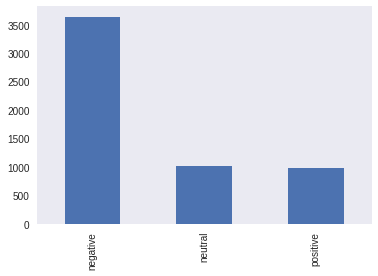

In [26]:
# look at the count of values for the 3 categories.
air_sub_df.airline_sentiment.value_counts().plot(kind='bar')
plt.grid(0)

In [20]:
air_sub_df.head()

,text,airline_sentiment,airline_sentiment_confidence,negativereason,airline
0,@VirginAmerica What @dhepburn said.,neutral,1.0000,NaN,Virgin America
1,@VirginAmerica plus you've added commercials t...,positive,0.3486,NaN,Virgin America
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,NaN,Virgin America
3,@VirginAmerica it's really aggressive to blast...,negative,1.0000,Bad Flight,Virgin America
4,@VirginAmerica and it's a really big bad thing...,negative,1.0000,Can't Tell,Virgin America


In [21]:
air_sub_df.iloc[1,0]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [13]:
air_sub_df[air_sub_df.airline_sentiment == 'positive']['text'][:10]

9     @VirginAmerica it was amazing, and arrived an ...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
12    @VirginAmerica This is such a great deal! Alre...
14                               @VirginAmerica Thanks!
16    @VirginAmerica So excited for my first cross c...
18                      I ❤️ flying @VirginAmerica. ☺️👍
19    @VirginAmerica you know what would be amazingl...
21    @VirginAmerica I love this graphic. http://t.c...
22    @VirginAmerica I love the hipster innovation. ...
34    @VirginAmerica this is great news!  America co...
Name: text, dtype: object

In [14]:
air_sub_df[air_sub_df.airline_sentiment == 'negative']['text'][:10]

3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
17    @VirginAmerica  I flew from NYC to SFO last we...
24    @VirginAmerica you guys messed up my seating.....
25    @VirginAmerica status match program.  I applie...
26    @VirginAmerica What happened 2 ur vegan food o...
28    @VirginAmerica amazing to me that we can't get...
30    @VirginAmerica hi! I just bked a cool birthday...
32    @VirginAmerica help, left expensive headphones...
Name: text, dtype: object

In [15]:
air_sub_df[air_sub_df.airline_sentiment == 'neutral']['text'][:10]

0                   @VirginAmerica What @dhepburn said.
23    @VirginAmerica will you be making BOS&gt;LAS n...
31    @VirginAmerica Are the hours of operation for ...
42    @VirginAmerica plz help me win my bid upgrade ...
44    @VirginAmerica are flights leaving Dallas for ...
48    @VirginAmerica @ladygaga @carrieunderwood Afte...
52    @VirginAmerica wish you flew out of Atlanta......
53    @VirginAmerica @ladygaga @carrieunderwood Juli...
54    @VirginAmerica Will flights be leaving Dallas ...
58    @VirginAmerica @ladygaga @carrieunderwood - Ca...
Name: text, dtype: object

In [8]:
# target.
y = air_sub_df['airline_sentiment']

In [9]:
# unique values of y.
y.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [10]:
#*********** Let's try to look at the top words in each of the categories, using CountVectorizer() *************

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
from nltk.stem.porter import PorterStemmer
import string

In [69]:
# exclude name of airlines from the tweets. 
exclude = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways',
           'americanair', 'jetblue', 'southwest', 'flight', 'flights',
           'URL', 'AT_USER', 'amp', 'amp;']

In [15]:
# define stop words. Use the defined 'english' stop words. I will add the airline names to that.
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(exclude)
exclude_punctuation = set(string.punctuation) 

In [34]:
def tokenize(text):
    return(text.split())

In [1]:
def cleaner(text):
    
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [17]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    word_lst = tokenize(text)
    out = [word.strip() for word in word_lst if word not in stop_words]   
    
    text = ' '.join(out)
    return(text)

In [18]:
def stemming(text):
    '''
    eliminate plurals and redundancy of words (ie thank, thanks)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)

In [19]:
def declump_emojis(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            print(i)
            em_txt = em_txt.replace(i,' '+i+' ')
        
    return(em_txt)

## Clean Text
```(eliminate web tags, punctuation, symbols...)```

In [20]:
air_sub_df.columns

Index(['text', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'airline'],
      dtype='object')

In [70]:
# create a new category 'clean_text' with clean text.
air_sub_df['clean_text'] = air_sub_df['text'].apply(cleaner)

In [22]:
# Let's see what the clean data looks like.

In [23]:
air_sub_df[['clean_text', 'text']][y=='positive'][:10]

,clean_text,text
9,it was amazing and arrived an hour early youre...,"@VirginAmerica it was amazing, and arrived an ..."
11,i lt3 pretty graphics so much better than mini...,@VirginAmerica I &lt;3 pretty graphics. so muc...
12,this is such a great deal already thinking abo...,@VirginAmerica This is such a great deal! Alre...
14,thanks,@VirginAmerica Thanks!
16,so excited for my first cross country flight l...,@VirginAmerica So excited for my first cross c...
18,i ❤️ flying ☺️👍,I ❤️ flying @VirginAmerica. ☺️👍
19,you know what would be amazingly awesome bosfl...,@VirginAmerica you know what would be amazingl...
21,i love this graphic,@VirginAmerica I love this graphic. http://t.c...
22,i love the hipster innovation you are a feel g...,@VirginAmerica I love the hipster innovation. ...
34,this is great news america could start flights...,@VirginAmerica this is great news! America co...


In [24]:
air_sub_df.loc[19, 'text']

'@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.'

In [25]:
air_sub_df.loc[19, 'clean_text']

'you know what would be amazingly awesome bosfll please i want to fly with only you'

In [26]:
air_sub_df[['clean_text', 'text']][y=='negative'][:10]

,clean_text,text
3,its really aggressive to blast obnoxious enter...,@VirginAmerica it's really aggressive to blast...
4,and its a really big bad thing about it,@VirginAmerica and it's a really big bad thing...
5,seriously would pay 30 a flight for seats that...,@VirginAmerica seriously would pay $30 a fligh...
17,i flew from nyc to sfo last week and couldnt f...,@VirginAmerica I flew from NYC to SFO last we...
24,you guys messed up my seating i reserved seati...,@VirginAmerica you guys messed up my seating.....
25,status match program i applied and its been th...,@VirginAmerica status match program. I applie...
26,what happened 2 ur vegan food options at least...,@VirginAmerica What happened 2 ur vegan food o...
28,amazing to me that we cant get any cold air fr...,@VirginAmerica amazing to me that we can't get...
30,hi i just bked a cool birthday trip with you b...,@VirginAmerica hi! I just bked a cool birthday...
32,help left expensive headphones on flight 89 ia...,"@VirginAmerica help, left expensive headphones..."


In [27]:
air_sub_df.loc[28, 'text']

"@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS"

In [28]:
air_sub_df.loc[28, 'clean_text']

'amazing to me that we cant get any cold air from the vents vx358 noair worstflightever roasted sfotobos'

In [29]:
air_sub_df[['clean_text', 'text']][y=='neutral'][:10]

,clean_text,text
0,what said,@VirginAmerica What @dhepburn said.
23,will you be making bosgtlas non stop permanent...,@VirginAmerica will you be making BOS&gt;LAS n...
31,are the hours of operation for the club at sfo...,@VirginAmerica Are the hours of operation for ...
42,plz help me win my bid upgrade for my flight 2...,@VirginAmerica plz help me win my bid upgrade ...
44,are flights leaving dallas for seattle on time...,@VirginAmerica are flights leaving Dallas for ...
48,after last night tribute soundofmusic oscars20...,@VirginAmerica @ladygaga @carrieunderwood Afte...
52,wish you flew out of atlanta soon,@VirginAmerica wish you flew out of Atlanta......
53,julie andrews hands down,@VirginAmerica @ladygaga @carrieunderwood Juli...
54,will flights be leaving dallas for la on febru...,@VirginAmerica Will flights be leaving Dallas ...
58,carrie,@VirginAmerica @ladygaga @carrieunderwood - Ca...


In [30]:
air_sub_df.loc[48, 'text']

'@VirginAmerica @ladygaga @carrieunderwood After last night #tribute #SoundOfMusic #Oscars2015 @ladygaga! I think @carrieunderwood agree'

In [31]:
air_sub_df.loc[48, 'clean_text']

'after last night tribute soundofmusic oscars2015 i think agree'

## Reduce dimensionality - using english stop words
```(eliminating english stop words that typically don't impart much meaning like prepositions, pronouns... I will also remove twitter handle and urls encoded above, in the cleaner method, as AT_USER and URL.```

In [71]:
# create a new category 'stopw_clean_text' to store reduced dimensionality text,
# by eliminating english stop words.
air_sub_df['stopw_clean_text'] = air_sub_df['clean_text'].apply(remove_stopwords)

In [36]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='positive'][:10]

,stopw_clean_text,clean_text
9,amazing arrived hour early youre good,it was amazing and arrived an hour early youre...
11,lt3 pretty graphics better minimal iconography d,i lt3 pretty graphics so much better than mini...
12,great deal thinking 2nd trip amp havent gone 1...,this is such a great deal already thinking abo...
14,thanks,thanks
16,excited cross country lax mco ive heard great ...,so excited for my first cross country flight l...
18,❤️ flying ☺️👍,i ❤️ flying ☺️👍
19,know amazingly awesome bosfll want fly,you know what would be amazingly awesome bosfl...
21,love graphic,i love this graphic
22,love hipster innovation feel good brand,i love the hipster innovation you are a feel g...
34,great news america start hawaii end year,this is great news america could start flights...


In [37]:
air_sub_df.loc[19, 'clean_text']

'you know what would be amazingly awesome bosfll please i want to fly with only you'

In [38]:
air_sub_df.loc[19, 'stopw_clean_text']

'know amazingly awesome bosfll want fly'

In [39]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='negative'][:10]

,stopw_clean_text,clean_text
3,really aggressive blast obnoxious entertainmen...,its really aggressive to blast obnoxious enter...
4,really big bad thing,and its a really big bad thing about it
5,seriously pay 30 seats didnt playing really ba...,seriously would pay 30 a flight for seats that...
17,flew nyc sfo week fully sit seat large gentlem...,i flew from nyc to sfo last week and couldnt f...
24,guys messed seating reserved seating friends g...,you guys messed up my seating i reserved seati...
25,status match program applied weeks called emai...,status match program i applied and its been th...
26,happened 2 ur vegan food options say ur site k...,what happened 2 ur vegan food options at least...
28,amazing cold air vents vx358 noair worstflight...,amazing to me that we cant get any cold air fr...
30,hi just bked cool birthday trip add elevate ca...,hi i just bked a cool birthday trip with you b...
32,help left expensive headphones 89 iad lax toda...,help left expensive headphones on flight 89 ia...


In [40]:
air_sub_df.loc[28, 'clean_text']

'amazing to me that we cant get any cold air from the vents vx358 noair worstflightever roasted sfotobos'

In [41]:
air_sub_df.loc[28, 'stopw_clean_text']

'amazing cold air vents vx358 noair worstflightever roasted sfotobos'

In [42]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='neutral'][:10]

,stopw_clean_text,clean_text
0,said,what said
23,making bosgtlas non stop permanently anytime soon,will you be making bosgtlas non stop permanent...
31,hours operation club sfo posted online current,are the hours of operation for the club at sfo...
42,plz help win bid upgrade 227 laxgtsea 🍷👍💺✈️,plz help me win my bid upgrade for my flight 2...
44,leaving dallas seattle time feb 24,are flights leaving dallas for seattle on time...
48,night tribute soundofmusic oscars2015 think agree,after last night tribute soundofmusic oscars20...
52,wish flew atlanta soon,wish you flew out of atlanta soon
53,julie andrews hands,julie andrews hands down
54,leaving dallas la february 24th,will flights be leaving dallas for la on febru...
58,carrie,carrie


In [43]:
air_sub_df.loc[48, 'clean_text']

'after last night tribute soundofmusic oscars2015 i think agree'

In [44]:
air_sub_df.loc[48, 'stopw_clean_text']

'night tribute soundofmusic oscars2015 think agree'

## Further reduce dimensionality - using stemming 
```(Stemming attempts to find the root of the word by chopping off the end, like thanks becoms thank...)```

In [72]:
# create a new category 'stem_stopw_clean_text' to store reduced dimensionality text,
# by finding root of words.
air_sub_df['stem_stopw_clean_text'] = air_sub_df['stopw_clean_text'].apply(stemming)

In [73]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='positive'][:10]

,stem_stopw_clean_text,stopw_clean_text
9,amaz arriv hour earli your good,amazing arrived hour early youre good
11,lt3 pretti graphic better minim iconographi d,lt3 pretty graphics better minimal iconography d
12,great deal think 2nd trip amp havent gone 1st ...,great deal thinking 2nd trip amp havent gone 1...
14,thank,thanks
16,excit cross countri lax mco ive heard great th...,excited cross country lax mco ive heard great ...
18,❤️ fli ☺️👍,❤️ flying ☺️👍
19,know amazingli awesom bosfll want fli,know amazingly awesome bosfll want fly
21,love graphic,love graphic
22,love hipster innov feel good brand,love hipster innovation feel good brand
34,great news america start hawaii end year,great news america start hawaii end year


In [47]:
air_sub_df.loc[19, 'stopw_clean_text']

'know amazingly awesome bosfll want fly'

In [48]:
air_sub_df.loc[19, 'stem_stopw_clean_text']

'know amazingli awesom bosfll want fli'

In [49]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='negative'][:10]

,stem_stopw_clean_text,stopw_clean_text
3,realli aggress blast obnoxi entertain guest fa...,really aggressive blast obnoxious entertainmen...
4,realli big bad thing,really big bad thing
5,serious pay 30 seat didnt play realli bad thin...,seriously pay 30 seats didnt playing really ba...
17,flew nyc sfo week fulli sit seat larg gentlema...,flew nyc sfo week fully sit seat large gentlem...
24,guy mess seat reserv seat friend guy gave seat...,guys messed seating reserved seating friends g...
25,statu match program appli week call email respons,status match program applied weeks called emai...
26,happen 2 ur vegan food option say ur site know...,happened 2 ur vegan food options say ur site k...
28,amaz cold air vent vx358 noair worstflightev r...,amazing cold air vents vx358 noair worstflight...
30,hi just bked cool birthday trip add elev caus ...,hi just bked cool birthday trip add elevate ca...
32,help left expens headphon 89 iad lax today sea...,help left expensive headphones 89 iad lax toda...


In [50]:
air_sub_df.loc[28, 'stopw_clean_text']

'amazing cold air vents vx358 noair worstflightever roasted sfotobos'

In [51]:
air_sub_df.loc[28, 'stem_stopw_clean_text']

'amaz cold air vent vx358 noair worstflightev roast sfotobo'

In [52]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='neutral'][:10]

,stem_stopw_clean_text,stopw_clean_text
0,said,said
23,make bosgtla non stop perman anytim soon,making bosgtlas non stop permanently anytime soon
31,hour oper club sfo post onlin current,hours operation club sfo posted online current
42,plz help win bid upgrad 227 laxgtsea 🍷👍💺✈️,plz help win bid upgrade 227 laxgtsea 🍷👍💺✈️
44,leav dalla seattl time feb 24,leaving dallas seattle time feb 24
48,night tribut soundofmus oscars2015 think agre,night tribute soundofmusic oscars2015 think agree
52,wish flew atlanta soon,wish flew atlanta soon
53,juli andrew hand,julie andrews hands
54,leav dalla la februari 24th,leaving dallas la february 24th
58,carri,carrie


In [53]:
air_sub_df.loc[48, 'stopw_clean_text']

'night tribute soundofmusic oscars2015 think agree'

In [54]:
air_sub_df.loc[48, 'stem_stopw_clean_text']

'night tribut soundofmus oscars2015 think agre'

In [55]:
# Let's make a word cloud to visualize the clean text data.

In [65]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask).generate(' '.join(i for i in data))
    plt.grid(0)
    plt.title(title, fontsize=14)
    im.to_file(img_out_dir+filename)
    plt.imshow(im)

## Positive class

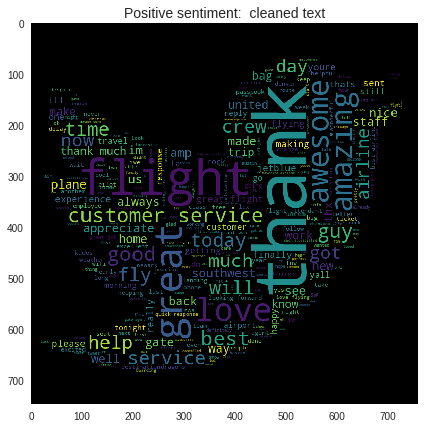

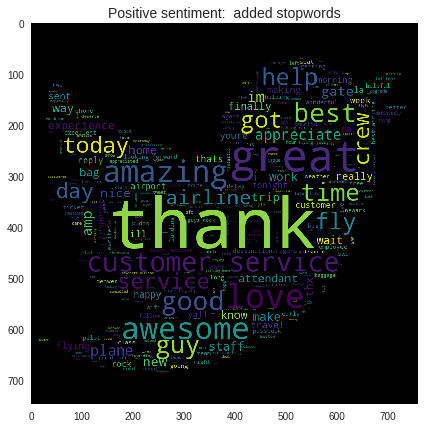

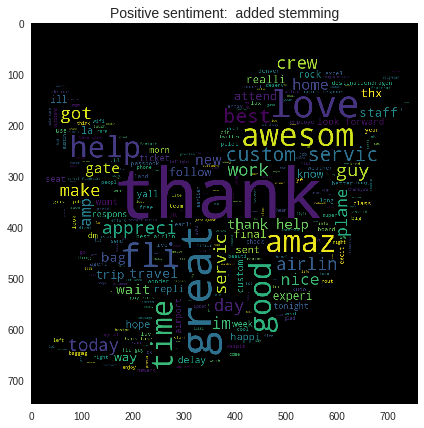

In [74]:
# twitter logo.
mask = wc_image_mask

# only cleaned text.
data = air_sub_df['clean_text'][y=='positive']
title = "Positive sentiment:  cleaned text"
filename = 'WordCld_pos_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stopwords"
filename = 'WordCld_pos_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stemming"
filename = 'WordCld_pos_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Negative class

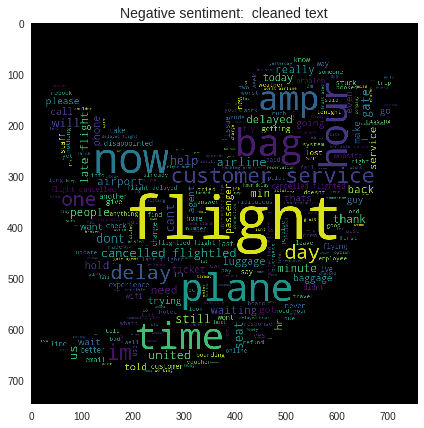

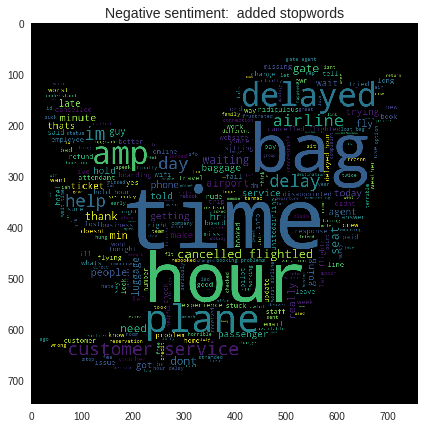

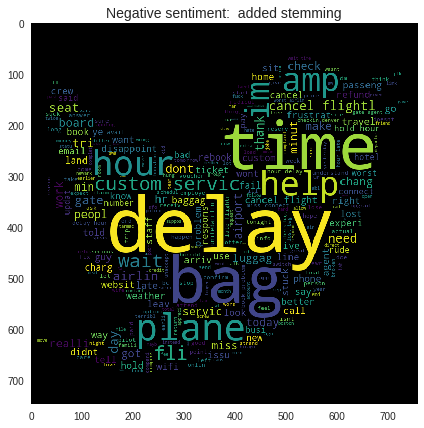

In [75]:
# only cleaned text.
data = air_sub_df['clean_text'][y=='negative']
title = "Negative sentiment:  cleaned text"
filename = 'WordCld_neg_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stopwords"
filename = 'WordCld_neg_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stemming"
filename = 'WordCld_neg_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

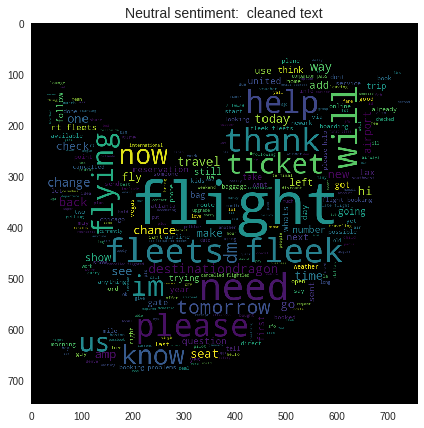

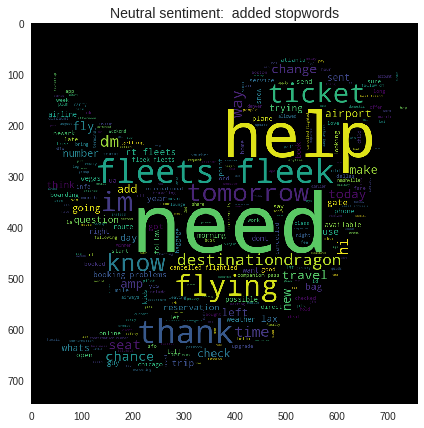

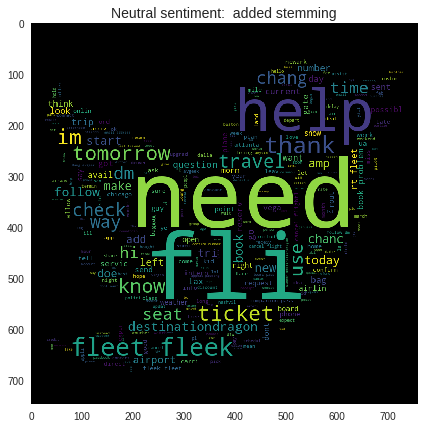

In [77]:
# only cleaned text.
data = air_sub_df['clean_text'][y=='neutral']
title = "Neutral sentiment:  cleaned text"
filename = 'WordCld_neut_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stopwords"
filename = 'WordCld_neut_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stemming"
filename = 'WordCld_neut_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Feature extraction using CountVectorizer() 
```compare results of using 'stemming' and 'not using stemming'.```

## Look at uni-grams 

In [78]:
grams = "Unigrams"

In [79]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(1,1))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(1,1))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(1,1))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y


In [80]:
print(words_df.shape)
words_df.head(4)

(5656, 8556)


,0162431184663,0167560070877,0214,021mbps,02272015,03,0510,0530,0769,10,...,zcc82u,zero,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
print(words_stop_df.shape)
words_stop_df.head(4)

(5656, 8296)


,0162431184663,0167560070877,0214,021mbps,02272015,03,0510,0530,0769,10,...,zcc82u,zero,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 6725)


,0162431184663,0167560070877,0214,021mbp,02272015,03,0510,0530,0769,10,...,yyzua70435,zcc82u,zero,zipper,zombi,zone,zoom,zrh,zuke,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# We see that the dimensions of the features reduced from 7904 with clean text, 
# to 7827 with stopwords and 7264 with stemming.

### Positive Sentiment

In [84]:
def disp_positive_grams(words_df, words_stop_df, words_stem_df, grams):
    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "positive"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)


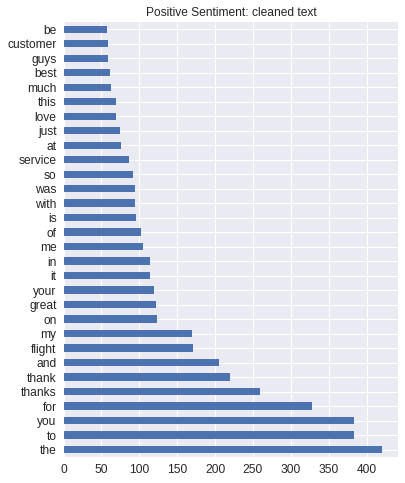

Index(['the', 'to', 'you', 'for', 'thanks', 'thank', 'and', 'flight', 'my',
       'on', 'great', 'your', 'it', 'in', 'me', 'of', 'is', 'with', 'was',
       'so', 'service', 'at', 'just', 'love', 'this', 'much', 'best', 'guys',
       'customer', 'be'],
      dtype='object')


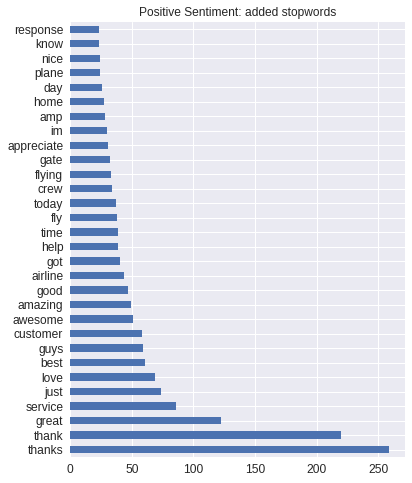

Index(['thanks', 'thank', 'great', 'service', 'just', 'love', 'best', 'guys',
       'customer', 'awesome', 'amazing', 'good', 'airline', 'got', 'help',
       'time', 'fly', 'today', 'crew', 'flying', 'gate', 'appreciate', 'im',
       'amp', 'home', 'day', 'plane', 'nice', 'know', 'response'],
      dtype='object')


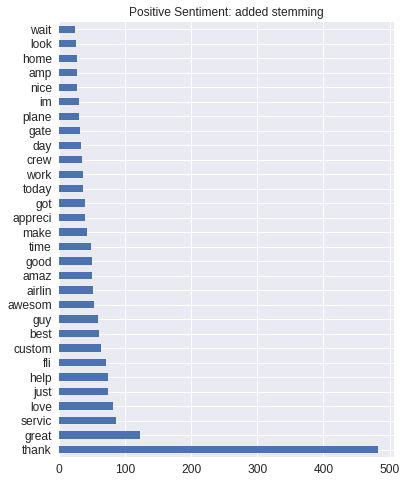

Index(['thank', 'great', 'servic', 'love', 'just', 'help', 'fli', 'custom',
       'best', 'guy', 'awesom', 'airlin', 'amaz', 'good', 'time', 'make',
       'appreci', 'got', 'today', 'work', 'crew', 'day', 'gate', 'plane', 'im',
       'nice', 'amp', 'home', 'look', 'wait'],
      dtype='object')


In [85]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [86]:
def disp_negative_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "negative"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

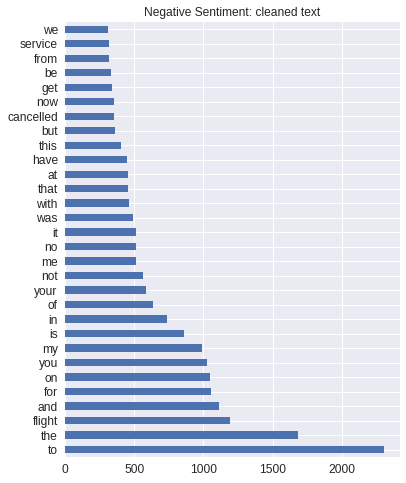

Index(['to', 'the', 'flight', 'and', 'for', 'on', 'you', 'my', 'is', 'in',
       'of', 'your', 'not', 'me', 'no', 'it', 'was', 'with', 'that', 'at',
       'have', 'this', 'but', 'cancelled', 'now', 'get', 'be', 'from',
       'service', 'we'],
      dtype='object')


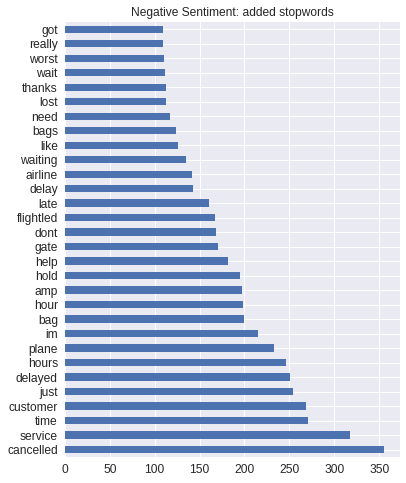

Index(['cancelled', 'service', 'time', 'customer', 'just', 'delayed', 'hours',
       'plane', 'im', 'bag', 'hour', 'amp', 'hold', 'help', 'gate', 'dont',
       'flightled', 'late', 'delay', 'airline', 'waiting', 'like', 'bags',
       'need', 'lost', 'thanks', 'wait', 'worst', 'really', 'got'],
      dtype='object')


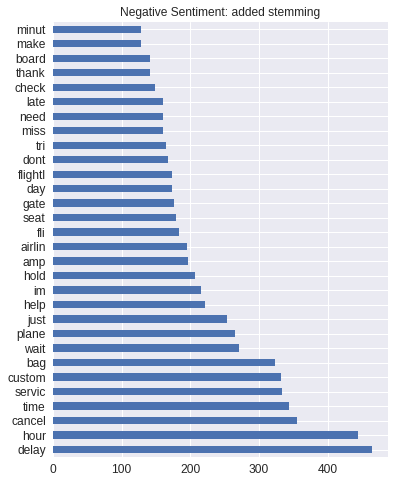

Index(['delay', 'hour', 'cancel', 'time', 'servic', 'custom', 'bag', 'wait',
       'plane', 'just', 'help', 'im', 'hold', 'amp', 'airlin', 'fli', 'seat',
       'gate', 'day', 'flightl', 'dont', 'tri', 'miss', 'need', 'late',
       'check', 'thank', 'board', 'make', 'minut'],
      dtype='object')


In [87]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [88]:
def disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "neutral"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

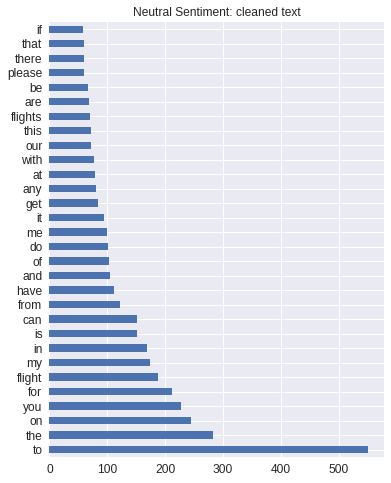

Index(['to', 'the', 'on', 'you', 'for', 'flight', 'my', 'in', 'is', 'can',
       'from', 'have', 'and', 'of', 'do', 'me', 'it', 'get', 'any', 'at',
       'with', 'our', 'this', 'flights', 'are', 'be', 'please', 'there',
       'that', 'if'],
      dtype='object')


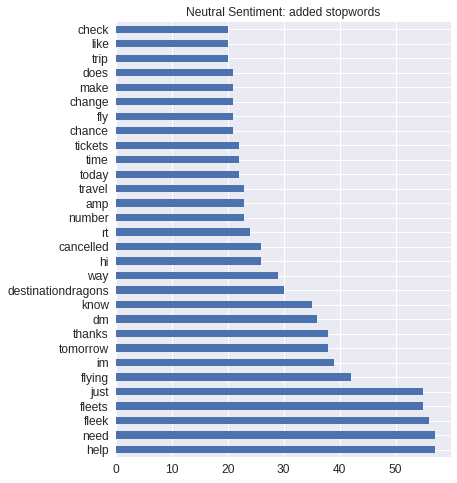

Index(['help', 'need', 'fleek', 'fleets', 'just', 'flying', 'im', 'tomorrow',
       'thanks', 'dm', 'know', 'destinationdragons', 'way', 'hi', 'cancelled',
       'rt', 'number', 'amp', 'travel', 'today', 'time', 'tickets', 'chance',
       'fly', 'change', 'make', 'does', 'trip', 'like', 'check'],
      dtype='object')


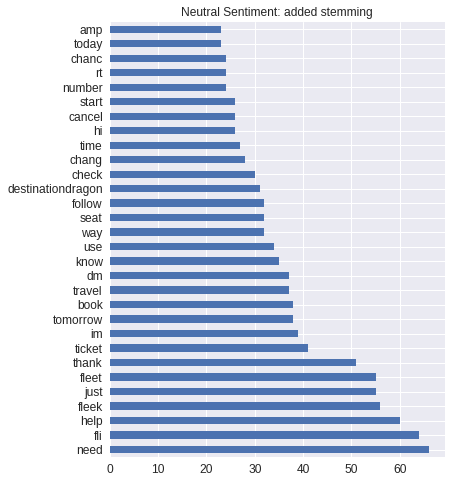

Index(['need', 'fli', 'help', 'fleek', 'just', 'fleet', 'thank', 'ticket',
       'im', 'tomorrow', 'book', 'travel', 'dm', 'know', 'use', 'way', 'seat',
       'follow', 'destinationdragon', 'check', 'chang', 'time', 'hi', 'cancel',
       'start', 'number', 'rt', 'chanc', 'today', 'amp'],
      dtype='object')


In [89]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at bi-grams

In [90]:
grams = "Bigrams"

In [91]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(2,2))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(2,2))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(2,2))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [92]:
print(words_df.shape)
words_df.head(4)

(5656, 46578)


,0162431184663 of,0167560070877 fsqthg,0214 when,021mbps amp,02272015 737300,03 for,0510 in,0510 the,0530 flight,0769 out,...,zippers sorry,zombie tomorrow,zone while,zone your,zones thanks,zoom out,zrh departed,zukes nonvegan,zurich bc,zurich why
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 33238)


,0162431184663 agents,0167560070877 fsqthg,0214 started,021mbps amp,02272015 737300,03 booking,0510 captain,0510 santo,0530 dfw,0769 lga,...,zippers sorry,zombie tomorrow,zone actually,zone forced,zones thanks,zoom scroll,zrh departed,zukes nonvegan,zurich bc,zurich credit
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 31726)


,0162431184663 agent,0167560070877 fsqthg,0214 start,021mbp amp,02272015 737300,03 book,0510 captain,0510 santo,0530 dfw,0769 lga,...,zipper sorri,zombi tomorrow,zone actual,zone forc,zone thank,zoom scroll,zrh depart,zuke nonvegan,zurich bc,zurich credit
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
# Feature dimension reduced from 47728 with cleaned text, to 35649 with stopwords and
# 34824 with stemming.

## Positive

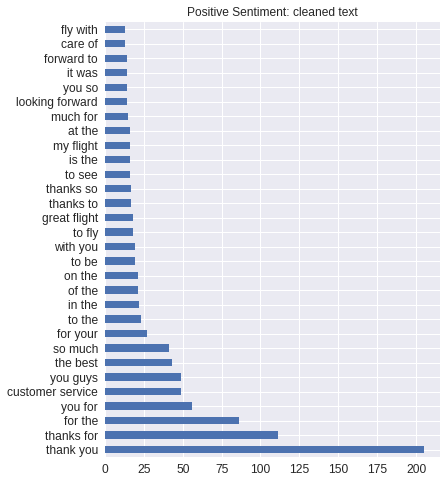

Index(['thank you', 'thanks for', 'for the', 'you for', 'customer service',
       'you guys', 'the best', 'so much', 'for your', 'to the', 'in the',
       'of the', 'on the', 'to be', 'with you', 'to fly', 'great flight',
       'thanks to', 'thanks so', 'to see', 'is the', 'my flight', 'at the',
       'much for', 'looking forward', 'you so', 'it was', 'forward to',
       'care of', 'fly with'],
      dtype='object')


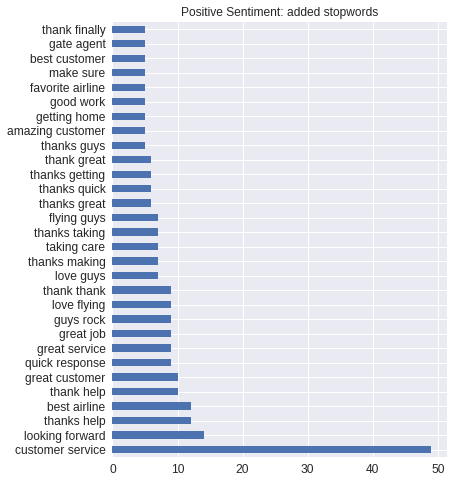

Index(['customer service', 'looking forward', 'thanks help', 'best airline',
       'thank help', 'great customer', 'quick response', 'great service',
       'great job', 'guys rock', 'love flying', 'thank thank', 'love guys',
       'thanks making', 'taking care', 'thanks taking', 'flying guys',
       'thanks great', 'thanks quick', 'thanks getting', 'thank great',
       'thanks guys', 'amazing customer', 'getting home', 'good work',
       'favorite airline', 'make sure', 'best customer', 'gate agent',
       'thank finally'],
      dtype='object')


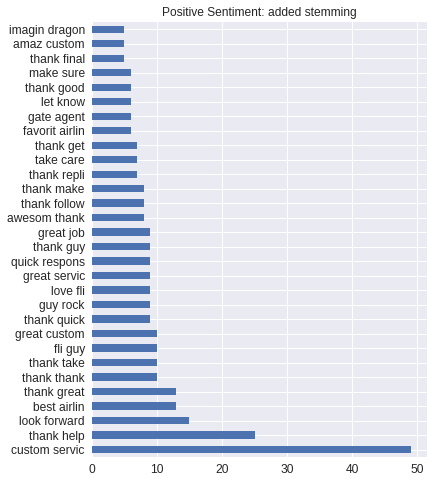

Index(['custom servic', 'thank help', 'look forward', 'best airlin',
       'thank great', 'thank thank', 'thank take', 'fli guy', 'great custom',
       'thank quick', 'guy rock', 'love fli', 'great servic', 'quick respons',
       'thank guy', 'great job', 'awesom thank', 'thank follow', 'thank make',
       'thank repli', 'take care', 'thank get', 'favorit airlin', 'gate agent',
       'let know', 'thank good', 'make sure', 'thank final', 'amaz custom',
       'imagin dragon'],
      dtype='object')


In [96]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

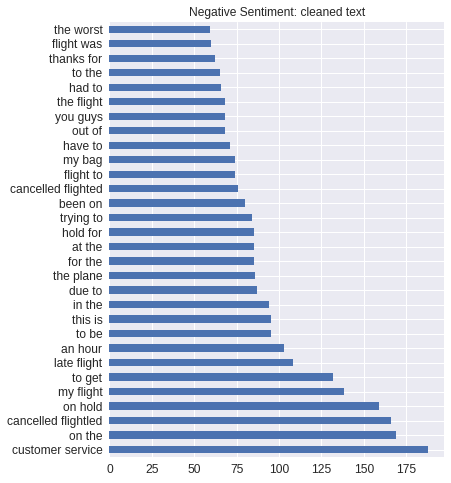

Index(['customer service', 'on the', 'cancelled flightled', 'on hold',
       'my flight', 'to get', 'late flight', 'an hour', 'to be', 'this is',
       'in the', 'due to', 'the plane', 'for the', 'at the', 'hold for',
       'trying to', 'been on', 'cancelled flighted', 'flight to', 'my bag',
       'have to', 'out of', 'you guys', 'the flight', 'had to', 'to the',
       'thanks for', 'flight was', 'the worst'],
      dtype='object')


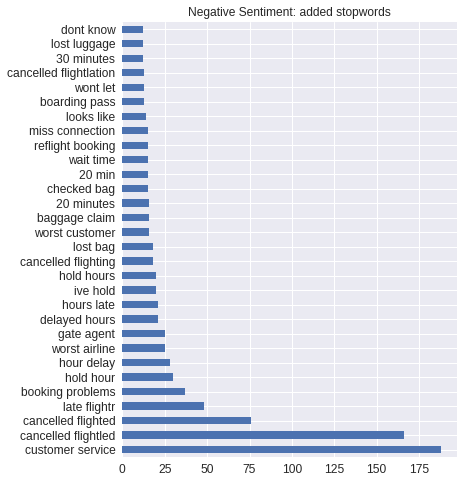

Index(['customer service', 'cancelled flightled', 'cancelled flighted',
       'late flightr', 'booking problems', 'hold hour', 'hour delay',
       'worst airline', 'gate agent', 'delayed hours', 'hours late',
       'ive hold', 'hold hours', 'cancelled flighting', 'lost bag',
       'worst customer', 'baggage claim', '20 minutes', 'checked bag',
       '20 min', 'wait time', 'reflight booking', 'miss connection',
       'looks like', 'boarding pass', 'wont let', 'cancelled flightlation',
       '30 minutes', 'lost luggage', 'dont know'],
      dtype='object')


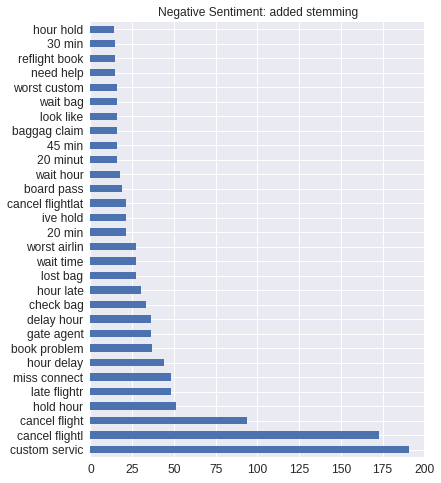

Index(['custom servic', 'cancel flightl', 'cancel flight', 'hold hour',
       'late flightr', 'miss connect', 'hour delay', 'book problem',
       'gate agent', 'delay hour', 'check bag', 'hour late', 'lost bag',
       'wait time', 'worst airlin', '20 min', 'ive hold', 'cancel flightlat',
       'board pass', 'wait hour', '20 minut', '45 min', 'baggag claim',
       'look like', 'wait bag', 'worst custom', 'need help', 'reflight book',
       '30 min', 'hour hold'],
      dtype='object')


In [97]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

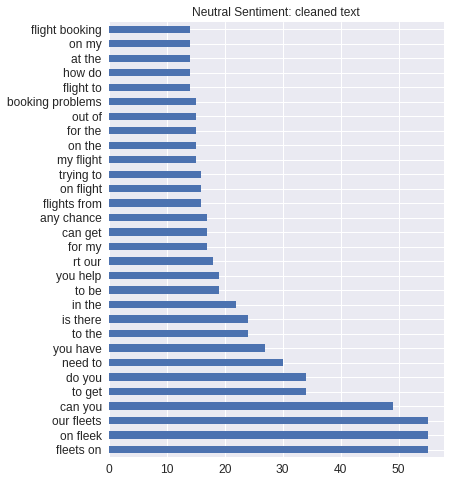

Index(['fleets on', 'on fleek', 'our fleets', 'can you', 'to get', 'do you',
       'need to', 'you have', 'to the', 'is there', 'in the', 'to be',
       'you help', 'rt our', 'for my', 'can get', 'any chance', 'flights from',
       'on flight', 'trying to', 'my flight', 'on the', 'for the', 'out of',
       'booking problems', 'flight to', 'how do', 'at the', 'on my',
       'flight booking'],
      dtype='object')


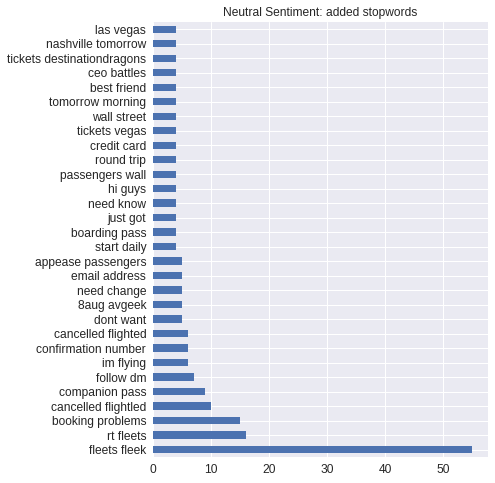

Index(['fleets fleek', 'rt fleets', 'booking problems', 'cancelled flightled',
       'companion pass', 'follow dm', 'im flying', 'confirmation number',
       'cancelled flighted', 'dont want', '8aug avgeek', 'need change',
       'email address', 'appease passengers', 'start daily', 'boarding pass',
       'just got', 'need know', 'hi guys', 'passengers wall', 'round trip',
       'credit card', 'tickets vegas', 'wall street', 'tomorrow morning',
       'best friend', 'ceo battles', 'tickets destinationdragons',
       'nashville tomorrow', 'las vegas'],
      dtype='object')


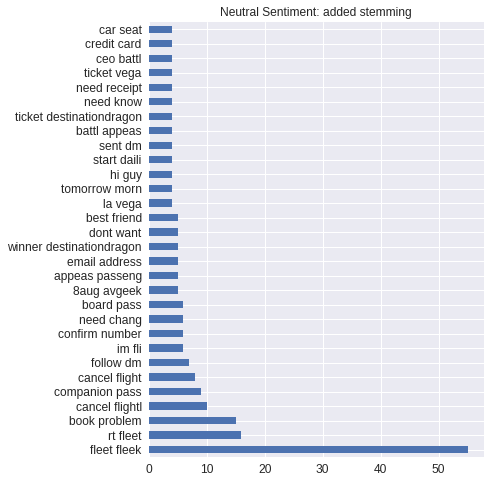

Index(['fleet fleek', 'rt fleet', 'book problem', 'cancel flightl',
       'companion pass', 'cancel flight', 'follow dm', 'im fli',
       'confirm number', 'need chang', 'board pass', '8aug avgeek',
       'appeas passeng', 'email address', 'winner destinationdragon',
       'dont want', 'best friend', 'la vega', 'tomorrow morn', 'hi guy',
       'start daili', 'sent dm', 'battl appeas', 'ticket destinationdragon',
       'need know', 'need receipt', 'ticket vega', 'ceo battl', 'credit card',
       'car seat'],
      dtype='object')


In [98]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at tri-grams

In [99]:
grams = "Trigrams"

In [100]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(3,3))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(3,3))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(3,3))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [101]:
# with stemming feature dimensionality reduced from 31667 to 31471.

In [102]:
print(words_df.shape)
words_df.head(1)

(5656, 68084)


,0162431184663 of your,0167560070877 fsqthg thanks,0214 when this,021mbps amp ended,03 for flight,0510 in santo,0510 the captain,0530 flight out,0769 out of,10 baggage claim,...,zero to keep,zero to protect,zero updates unitedairlinessux,zone while get,zone your actually,zoom out or,zrh departed 245hrs,zukes nonvegan yogurt,zurich bc of,zurich why would
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 33200)


,0162431184663 agents said,0167560070877 fsqthg thanks,0214 started phone,021mbps amp ended,03 booking problems,0510 captain informs,0510 santo domingo,0530 dfw tuesday,0769 lga dfw,10 1115p construction,...,zero meaningful assistance,zero people stepping,zero protect daughter,zero safealone plastic,zero updates unitedairlinessux,zoom scroll touch,zrh departed 245hrs,zukes nonvegan yogurt,zurich bc fault,zurich credit miles
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
print(words_stem_df.shape)
words_stem_df.head(1)

(5656, 33000)


,0162431184663 agent said,0167560070877 fsqthg thank,0214 start phone,021mbp amp end,03 book problem,0510 captain inform,0510 santo domingo,0530 dfw tuesday,0769 lga dfw,10 1115p construct,...,zero meaning assist,zero peopl step,zero protect daughter,zero safealon plastic,zero updat unitedairlinessux,zoom scroll touch,zrh depart 245hr,zuke nonvegan yogurt,zurich bc fault,zurich credit mile
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# dimensionality reduced from 72896, to 36572, 36269

## Positive

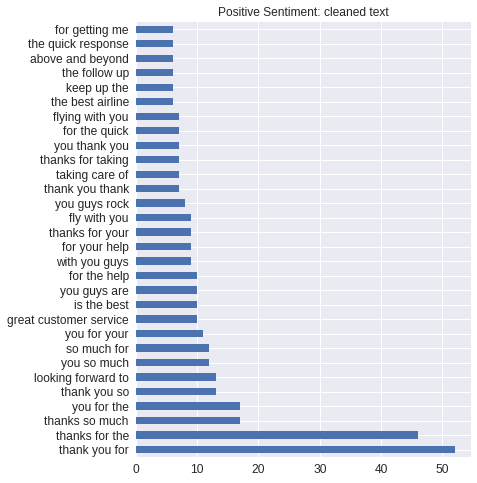

Index(['thank you for', 'thanks for the', 'thanks so much', 'you for the',
       'thank you so', 'looking forward to', 'you so much', 'so much for',
       'you for your', 'great customer service', 'is the best', 'you guys are',
       'for the help', 'with you guys', 'for your help', 'thanks for your',
       'fly with you', 'you guys rock', 'thank you thank', 'taking care of',
       'thanks for taking', 'you thank you', 'for the quick',
       'flying with you', 'the best airline', 'keep up the', 'the follow up',
       'above and beyond', 'the quick response', 'for getting me'],
      dtype='object')


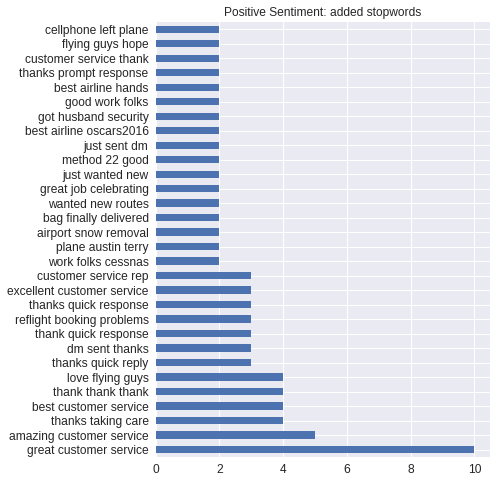

Index(['great customer service', 'amazing customer service',
       'thanks taking care', 'best customer service', 'thank thank thank',
       'love flying guys', 'thanks quick reply', 'dm sent thanks',
       'thank quick response', 'reflight booking problems',
       'thanks quick response', 'excellent customer service',
       'customer service rep', 'work folks cessnas', 'plane austin terry',
       'airport snow removal', 'bag finally delivered', 'wanted new routes',
       'great job celebrating', 'just wanted new', 'method 22 good',
       'just sent dm', 'best airline oscars2016', 'got husband security',
       'good work folks', 'best airline hands', 'thanks prompt response',
       'customer service thank', 'flying guys hope', 'cellphone left plane'],
      dtype='object')


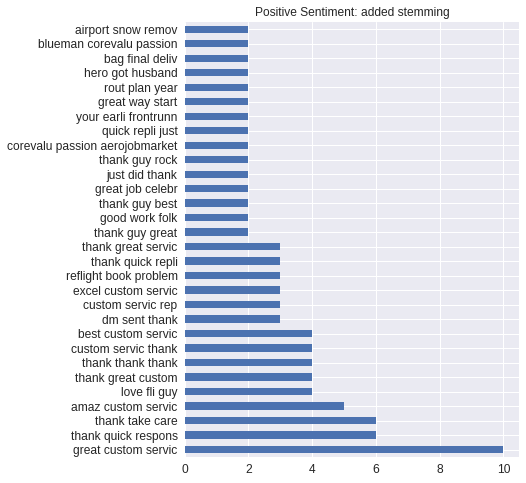

Index(['great custom servic', 'thank quick respons', 'thank take care',
       'amaz custom servic', 'love fli guy', 'thank great custom',
       'thank thank thank', 'custom servic thank', 'best custom servic',
       'dm sent thank', 'custom servic rep', 'excel custom servic',
       'reflight book problem', 'thank quick repli', 'thank great servic',
       'thank guy great', 'good work folk', 'thank guy best',
       'great job celebr', 'just did thank', 'thank guy rock',
       'corevalu passion aerojobmarket', 'quick repli just',
       'your earli frontrunn', 'great way start', 'rout plan year',
       'hero got husband', 'bag final deliv', 'blueman corevalu passion',
       'airport snow remov'],
      dtype='object')


In [106]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

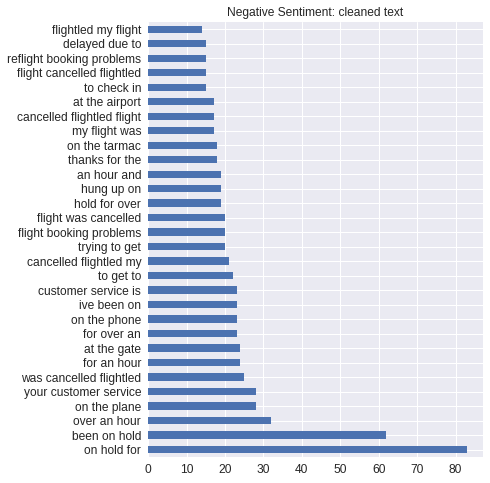

Index(['on hold for', 'been on hold', 'over an hour', 'on the plane',
       'your customer service', 'was cancelled flightled', 'for an hour',
       'at the gate', 'for over an', 'on the phone', 'ive been on',
       'customer service is', 'to get to', 'cancelled flightled my',
       'trying to get', 'flight booking problems', 'flight was cancelled',
       'hold for over', 'hung up on', 'an hour and', 'thanks for the',
       'on the tarmac', 'my flight was', 'cancelled flightled flight',
       'at the airport', 'to check in', 'flight cancelled flightled',
       'reflight booking problems', 'delayed due to', 'flightled my flight'],
      dtype='object')


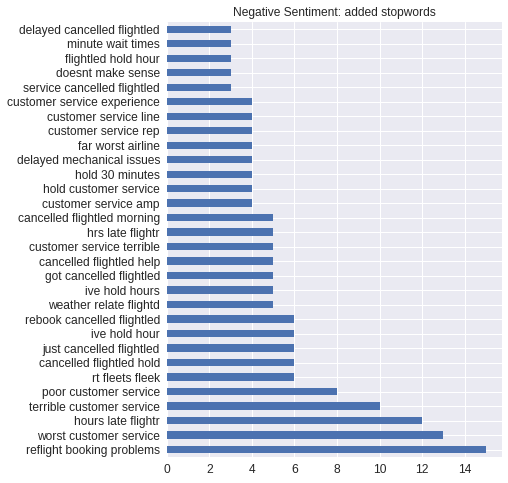

Index(['reflight booking problems', 'worst customer service',
       'hours late flightr', 'terrible customer service',
       'poor customer service', 'rt fleets fleek', 'cancelled flightled hold',
       'just cancelled flightled', 'ive hold hour',
       'rebook cancelled flightled', 'weather relate flightd',
       'ive hold hours', 'got cancelled flightled', 'cancelled flightled help',
       'customer service terrible', 'hrs late flightr',
       'cancelled flightled morning', 'customer service amp',
       'hold customer service', 'hold 30 minutes', 'delayed mechanical issues',
       'far worst airline', 'customer service rep', 'customer service line',
       'customer service experience', 'service cancelled flightled',
       'doesnt make sense', 'flightled hold hour', 'minute wait times',
       'delayed cancelled flightled'],
      dtype='object')


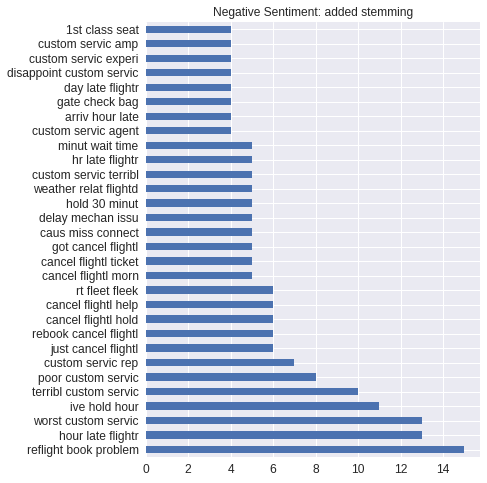

Index(['reflight book problem', 'hour late flightr', 'worst custom servic',
       'ive hold hour', 'terribl custom servic', 'poor custom servic',
       'custom servic rep', 'just cancel flightl', 'rebook cancel flightl',
       'cancel flightl hold', 'cancel flightl help', 'rt fleet fleek',
       'cancel flightl morn', 'cancel flightl ticket', 'got cancel flightl',
       'caus miss connect', 'delay mechan issu', 'hold 30 minut',
       'weather relat flightd', 'custom servic terribl', 'hr late flightr',
       'minut wait time', 'custom servic agent', 'arriv hour late',
       'gate check bag', 'day late flightr', 'disappoint custom servic',
       'custom servic experi', 'custom servic amp', '1st class seat'],
      dtype='object')


In [107]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

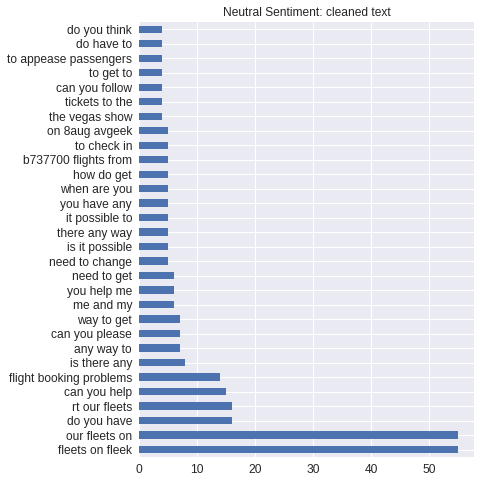

Index(['fleets on fleek', 'our fleets on', 'do you have', 'rt our fleets',
       'can you help', 'flight booking problems', 'is there any', 'any way to',
       'can you please', 'way to get', 'me and my', 'you help me',
       'need to get', 'need to change', 'is it possible', 'there any way',
       'it possible to', 'you have any', 'when are you', 'how do get',
       'b737700 flights from', 'to check in', 'on 8aug avgeek',
       'the vegas show', 'tickets to the', 'can you follow', 'to get to',
       'to appease passengers', 'do have to', 'do you think'],
      dtype='object')


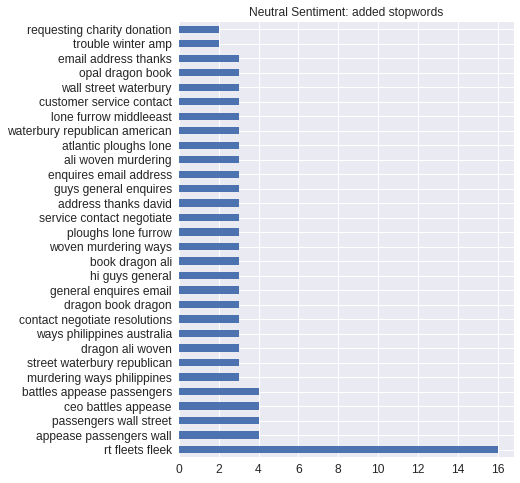

Index(['rt fleets fleek', 'appease passengers wall', 'passengers wall street',
       'ceo battles appease', 'battles appease passengers',
       'murdering ways philippines', 'street waterbury republican',
       'dragon ali woven', 'ways philippines australia',
       'contact negotiate resolutions', 'dragon book dragon',
       'general enquires email', 'hi guys general', 'book dragon ali',
       'woven murdering ways', 'ploughs lone furrow',
       'service contact negotiate', 'address thanks david',
       'guys general enquires', 'enquires email address',
       'ali woven murdering', 'atlantic ploughs lone',
       'waterbury republican american', 'lone furrow middleeast',
       'customer service contact', 'wall street waterbury', 'opal dragon book',
       'email address thanks', 'trouble winter amp',
       'requesting charity donation'],
      dtype='object')


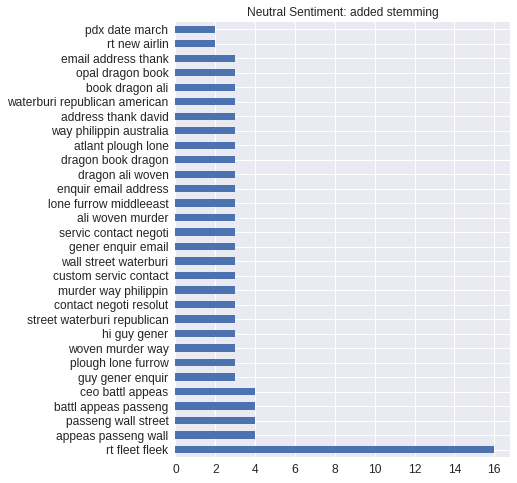

Index(['rt fleet fleek', 'appeas passeng wall', 'passeng wall street',
       'battl appeas passeng', 'ceo battl appeas', 'guy gener enquir',
       'plough lone furrow', 'woven murder way', 'hi guy gener',
       'street waterburi republican', 'contact negoti resolut',
       'murder way philippin', 'custom servic contact',
       'wall street waterburi', 'gener enquir email', 'servic contact negoti',
       'ali woven murder', 'lone furrow middleeast', 'enquir email address',
       'dragon ali woven', 'dragon book dragon', 'atlant plough lone',
       'way philippin australia', 'address thank david',
       'waterburi republican american', 'book dragon ali', 'opal dragon book',
       'email address thank', 'rt new airlin', 'pdx date march'],
      dtype='object')


In [108]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

In [109]:
# Pickle dataframe with added columns with processed and cleaned text.
import pickle

In [110]:
filename = data_out_dir+'airline_cl_process_dataset_df1'
filehandler = open(filename,"wb")
pickle.dump(air_sub_df,filehandler)

In [111]:
file = open(filename,'rb')
object_content = pickle.load(file)

In [112]:
type(object_content)

pandas.core.frame.DataFrame

In [162]:
object_content.columns, object_content.shape

(Index(['text', 'airline_sentiment', 'airline_sentiment_confidence',
        'negativereason', 'airline', 'clean_text', 'stopw_clean_text',
        'stem_stopw_clean_text'],
       dtype='object'), (5656, 8))